In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from jia_modif import multi_regime, F, G, new_diagn, new_deaths, multi_regime_cidades, tot_deaths
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
sns.set_style("darkgrid")

### Sistema de Equações para a cidade A

$$
\begin{cases}
\displaystyle \frac{\mathrm{d}S_1}{\mathrm{d}t} &= -\beta_1 S_1\left(I_1 + \theta_1 A_1\right) - p_1 S_1 + \lambda_1 Q_1 - \mu_1 S_1 + \mu_2 S_2\\
\displaystyle \frac{\mathrm{d}Q_1}{\mathrm{d}t} &= p_1 S_1 - \lambda_1 Q_1\\
\displaystyle \frac{\mathrm{d}E_1}{\mathrm{d}t} &= \beta_1 S_1(I_1 + \theta_1 A_1) - \sigma_1 E_1 - \mu_1 E_1 + \mu_2 E_2\\
\displaystyle \frac{\mathrm{d}A_1}{\mathrm{d}t} &= \sigma_1(1- \rho_1)E_1 - \epsilon_{A_1} A_1 - \gamma_{A_1} A_1 - \mu_1 A_1 + \mu_2 A_2\\
\displaystyle \frac{\mathrm{d}I_1}{\mathrm{d}t} &= \sigma_1\rho_1 E_1 - \epsilon_{I_1} I_1 - \gamma_{D_1} D_1 - d_{D_1} D_1 - \delta_1 I_1 + \delta_2 I_2\\\
\displaystyle \frac{\mathrm{d}R_1}{\mathrm{d}t} &= \gamma_{A_1} A_1 + \gamma_{I_1} I_1 + \gamma_{D_1} D_1  - \mu_1 R_1 + \mu_2 R_2
\end{cases}
$$

### Sistema de Equações para a Cidade B

$$
\begin{cases}
\displaystyle\frac{\mathrm{d}S_2}{\mathrm{d}t} &= -\beta_2 S_2\left(I_2 + \theta_2 A_2\right) - p_2 S_2 + \lambda_2 Q_2 - \mu_2 S_2 + \mu_1 S_1\\
\displaystyle\frac{\mathrm{d}Q_2}{\mathrm{d}t} &= p_2 S_2 - \lambda_2 Q_2\\
\displaystyle\frac{\mathrm{d}E_2}{\mathrm{d}t} &= \beta_2 S_2(I_2 + \theta_2 A_2) - \sigma_2 E_2 - \mu_2 E_2 + \mu_1 E_1\\
\displaystyle\frac{\mathrm{d}A_2}{\mathrm{d}t} &= \sigma_2(1- \rho_2)E_2 - \epsilon_{A_2} A_2 - \gamma_{A_2} A_2 - \mu_2 A_2 + \mu_1 A_1\\
\displaystyle\frac{\mathrm{d}I_2}{\mathrm{d}t} &= \sigma_2\rho_2 E_2 - \epsilon_{I_2} I_2 - \gamma_{D_2} D_2 - d_{D_2} D_2 - \delta_2 I_2 + \delta_1 I_1\\
\displaystyle\frac{\mathrm{d}R_1}{\mathrm{d}t} &= \gamma_{A_1} A_1 + \gamma_{I_1} I_1 + \gamma_{D_1} D_1 - \mu_2 R_2 + \mu_1 R_1
\end{cases}
$$

### Representação por ação de massas da primeira cidade

$$
\begin{cases}
S_1 + I_1 \stackrel{\beta_1}{\longrightarrow} E_1 + I_1 \\
S_1 + A_1 \stackrel{\beta_1 \theta_1}{\longrightarrow} E_1 + A_1 \\
S_1 \stackrel{p_1}{\longrightarrow} Q_1 \\
Q_1 \stackrel{\lambda_1}{\longrightarrow} S_1 \\
E_1 \stackrel{\sigma_1 \rho}{\longrightarrow} I_1 \\
E_1 \stackrel{\sigma_1 (1-\rho)}{\longrightarrow} A_1 \\
I_1 \stackrel{\epsilon_{I_1}}{\longrightarrow} D_1 \\
A_1 \stackrel{\epsilon_{A_1}}{\longrightarrow} D_1 \\
I_1 \stackrel{\gamma_{I_1}}{\longrightarrow} R_1 \\
A_1 \stackrel{\gamma_{A_1}}{\longrightarrow} R_1 \\
D_1 \stackrel{\gamma_{D_1}}{\longrightarrow} R_1 \\
S_1 + E_1 + A_1 \stackrel{\mu_1}{\longrightarrow} S_2 + E_2 + A_2 \\
I_1 \stackrel{\delta_1}{\longrightarrow} I_2 \\
S_2 + E_2 + A_2 \stackrel{\mu_2}{\longrightarrow} S_1 + E_1 + A_1 \\
I_2 \stackrel{\delta_2}{\longrightarrow} I_1 \\
\end{cases}
$$

In [3]:
# Taxa de subnotificação
taxa_subn   = 8
# Proporção de infectados assintomáticos
prop_assint = 0.80

In [4]:
# Dados para a cidade do Rio de Janeiro,
# IBGE 2019 (estimativa)
pop_Rio = 6718903
# 01 de Abril
diagn_Rio, recup_Rio = 697, 23
infect_Rio = diagn_Rio*(taxa_subn-1)*(1 - prop_assint)
assint_Rio = diagn_Rio*(taxa_subn-1)*prop_assint
expostos_Rio = diagn_Rio*7
quarentena_Rio = 0.6 * pop_Rio

sucetiveis_Rio = pop_Rio - (quarentena_Rio + expostos_Rio + assint_Rio + infect_Rio + diagn_Rio + recup_Rio)

In [5]:
# Dados para a cidade de São Paulo
# IBGE 2019 (estimativa)
pop_Cid = 12.2e6 
# 01 de Abril
diagn_Cid, recup_Cid = 1503, 50
infect_Cid = diagn_Cid*(taxa_subn-1)*(1 - prop_assint)
assint_Cid = diagn_Cid*(taxa_subn-1)*prop_assint
expostos_Cid = diagn_Cid*7
quarentena_Cid = 0.6 * pop_Cid

sucetiveis_Cid = pop_Cid- (quarentena_Cid + expostos_Cid + assint_Cid + infect_Cid + diagn_Cid + recup_Cid)

In [6]:
# condições iniciais
CI_rio = [sucetiveis_Rio, quarentena_Rio, expostos_Rio, assint_Rio, infect_Rio, diagn_Rio, recup_Rio]
CI_cid = [sucetiveis_Cid, quarentena_Cid, expostos_Cid, assint_Cid, infect_Cid, diagn_Cid, recup_Cid]
CI = CI_rio + CI_cid

## Problema

$\mu$ não pode assumir valor $> 0.7$, ele para a solução antes do tempo 
quanto maior o valor, mais cedo para a solução

Estamos supondo que $1000$ pessoas saem de São Paulo para Rio (e vice-versa) diariamente.

In [7]:
# conta para somar mil pessoas indo do rio pra sao paulo em um dia e de sao paulo pro rio em um dia
2e-5*pop_Rio + 1.3e-4*pop_Rio, 7.2e-5*pop_Cid + 1e-5*pop_Cid

(1007.8354499999999, 1000.4)

In [8]:
# Idx       :         0,    1,   2,      3,     4,    5,     6,      7,    8,      9,     10,     11,     12  13  14
# Parâmetros:      beta,  theta,   p, lambda, sigma, rho,  epsA, gammaA, epsI, gammaI, deathI, gammaD, deathD  mu  delta
params_rio_base = [1e-7, 1/10, 1/4,    1/6,   1/7, 0.94, 1/100, 0.0996, 1/30, 0.0766, 0.0026, 0.0843, 0.0017, 1.3e-4, 2e-5]

# Idx       :         0,    1,   2,      3,     4,    5,     6,      7,    8,      9,     10,     11,     12  13  14
# Parâmetros:      beta,  theta,   p, lambda, sigma, rho,  epsA, gammaA, epsI, gammaI, deathI, gammaD, deathD  mu delta
params_cid_base = [0.5e-7, 1/10, 1/4,    1/6,   1/7, 0.94, 1/100, 0.00996, 1/30, 0.0766, 0.0026, 0.0843, 0.0017, 7.2e-5, 1e-5]
params = [[i,j] for i,j in zip(params_rio_base, params_cid_base)]

In [9]:
# Do dia 01/04 até o dia 15/04
dados_Rio = [
    [114, 110, 60, 115, 86, 42, 141, 198, 184, 175, 97, 91, 326, 71, 126],
    [4,   7,  5,   2,  4,  5,  12,  14,   9,  10,  6,  8,   9, 25,  27]
]

In [10]:
# Do dia 01/04 até o dia 15/04
# dados de São Paulo
dados_Cid = [ 
    [  17,  801,  408,  883,  142,  749,  634,  695,  547,  206,  220,
         26,  162, 1031,  865],
    [  24,   15,   33,    6,   25,
         53,   44,   45,   26,   10,   23,   11,   64,   43,   47]
] 

In [11]:
T_fim = len(dados_Rio[0])

start = dt.datetime.strptime("1-04-2020", "%d-%m-%Y")
then = start + dt.timedelta(days=T_fim)
days = mdates.drange(start,then,dt.timedelta(days=1))

In [12]:
# Supondo mantida a quarentena
f_rio_base = lambda t,v: G(t,v, params)
results_base = solve_ivp(f_rio_base, (1,T_fim), CI, t_eval=range(1,T_fim+1))

In [13]:
diagn = new_diagn(results_base.y, params)
deaths = new_deaths(results_base.y, params)

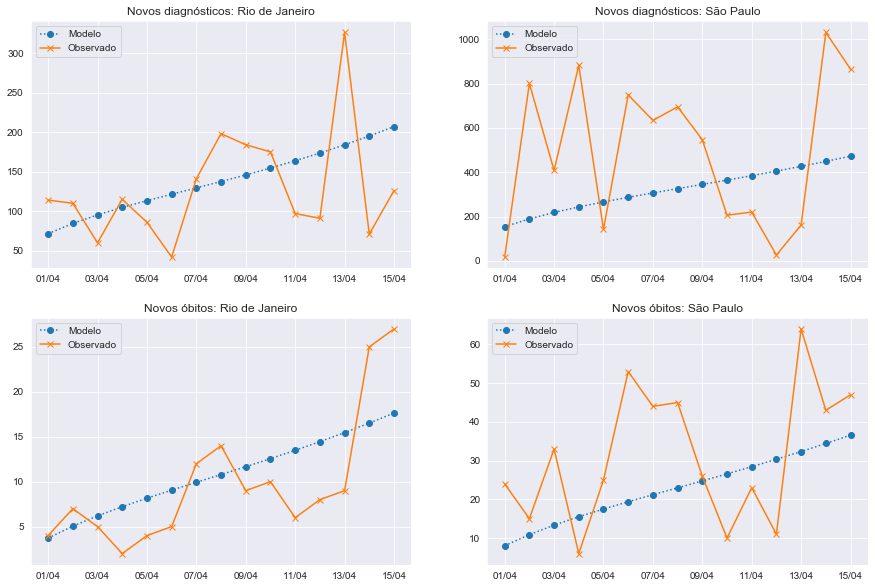

In [26]:
fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols=2, figsize=(15,10))

#diagn = new_diagn(results_base.y, params_rio_base)
ax1.plot(days, diagn[0],        'o:', label='Modelo')
ax1.plot(days, dados_Rio[0], 'x-', label='Observado')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax1.grid(color = 'white')
ax1.legend()
ax1.set_title('Novos diagnósticos: Rio de Janeiro')
cidade = 'São Paulo'
#diagn = new_diagn(results_base.y, params_rio_base)
ax2.plot(days, diagn[1],        'o:', label='Modelo')
ax2.plot(days, dados_Cid[0], 'x-', label='Observado')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax2.grid(color = 'white')
ax2.legend()
ax2.set_title('Novos diagnósticos: ' + str(cidade))

ax3.plot(days, deaths[0],       'o:', label = 'Modelo')
ax3.plot(days, dados_Rio[1], 'x-', label='Observado')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax3.grid(color = 'white')
ax3.legend()
ax3.set_title('Novos óbitos: Rio de Janeiro')

ax4.plot(days, deaths[1],       'o:', label = 'Modelo')
ax4.plot(days, dados_Cid[1], 'x-', label='Observado')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax4.grid(color = 'white')
ax4.legend()
ax4.set_title('Novos óbitos: ' + str(cidade))
plt.show()

### Abrindo tudo por dois dias:

In [15]:
# supondo circulação de 100.000 pessoas entre as duas cidades (por dia), logo, sem quarentena:
2e-3*pop_Rio + 1.3e-2*pop_Rio, 7.2e-3*pop_Cid + 1e-3*pop_Cid

(100783.545, 100040.0)

In [16]:
params = [[i,j] for i,j in zip(params_rio_base, params_cid_base)]
p1 = [p.copy() for p in params]
p1[-2][0], p1[-2][1] = 2e-3, 7.2e-3 # mu
p1[-1][0], p1[-1][1] = 1.3e-3, 1e-3 # delta
p1[2][0], p1[2][1] = 0, 0 #p
p1[3][0], p1[3][1] = 1, 1  #lambda

dia_h = 5
dia_d = 7
dia_final = 30

t_par = [[dia_h, params], [dia_d, p1], [dia_final, params]] # abrir a quarentena por 15 dias
t_par2 = [[30,params]] # manter a quarentena do mesmo jeito

In [17]:
sol_multi_regime1 = multi_regime_cidades(CI, 0, t_par)
sol_multi_regime2 = multi_regime_cidades(CI, 0, t_par2)
ts = np.arange(len(sol_multi_regime1[0]))
legends = ['Suscetíveis', 'Quarentenados', 'Expostos', 'Assintomáticos', 'Infectados', 'Diagnosticados', 'Recuperados']
titles = ['Rio de Janeiro', 'Segunda Cidade', 'Diferença entre os regimes (Rio de Janeiro)', 'Diferença entre os regimes (segunda cidade)' ]

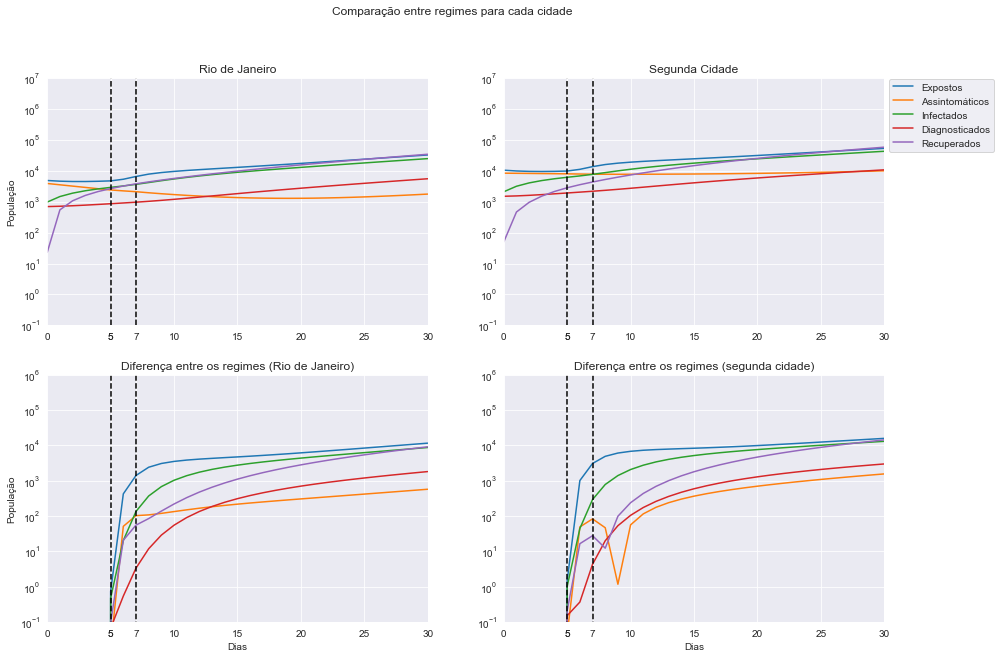

In [27]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows = 2,ncols = 2, figsize=(15,10))
fig.suptitle('Comparação entre regimes para cada cidade')
for i in range(2,7):
    ax1.semilogy(ts, sol_multi_regime1[i], label = legends[i])
    ax2.semilogy(ts, sol_multi_regime1[i+7], label = legends[i])
    ax3.semilogy(ts, np.abs(sol_multi_regime1[i]-sol_multi_regime2[i]), label = legends[i])
    ax4.semilogy(ts, np.abs(sol_multi_regime1[i+7]-sol_multi_regime2[i+7]), label = legends[i])
    
eixos = [ax1,ax2,ax3,ax4]
for (i,eixo) in enumerate(eixos):
    eixo.plot([dia_h, dia_h], [-1e7,1e7], '--', color = 'k')
    eixo.plot([dia_d, dia_d], [-1e7,1e7], '--', color = 'k')
    eixo.grid(True)
    eixo.set_title(titles[i])
    eixo.set_xticks(list(eixo.get_xticks()) + [dia_h, dia_d])
    eixo.set_xlim(0, dia_final)
    
ax1.set_ylim(0.1,1e7)
ax2.set_ylim(0.1,1e7)
ax3.set_ylim(0.1, 1e6)
ax4.set_ylim(0.1, 1e6)

ax3.set_xlabel('Dias')
ax4.set_xlabel('Dias')
ax1.set_ylabel('População')
ax3.set_ylabel('População')

ax3.legend(loc='center left', bbox_to_anchor=(2.2, 2.05))
plt.show()

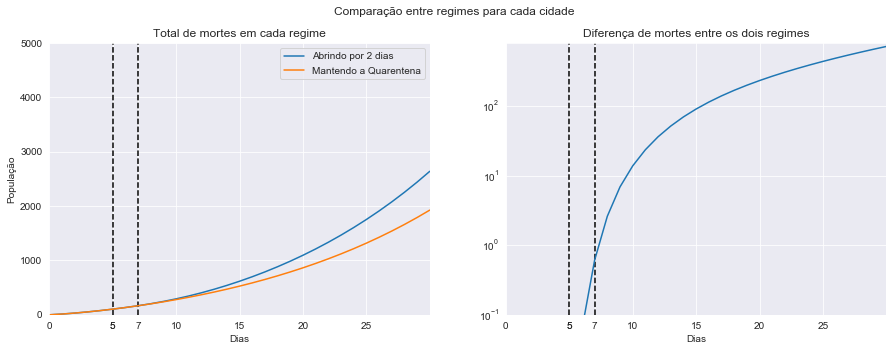

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15,5))
fig.suptitle('Comparação entre regimes para cada cidade')
eixos = [ax1,ax2]
for eixo in eixos:
    eixo.set_xticks(list(np.arange(0,dia_final, 5)) + [dia_h, dia_d])
    eixo.set_xlim(0, dia_final)
    eixo.plot([dia_h, dia_h], [0.1,1e7], '--', color = 'k')
    eixo.plot([dia_d, dia_d], [0.1,1e7], '--', color = 'k')
    eixo.grid(True)
    
ax1.plot(tot_deaths(sol_multi_regime1), label='Abrindo por ' + str(dia_d - dia_h)+ ' dias')
ax1.plot(tot_deaths(sol_multi_regime2), label='Mantendo a Quarentena')

ax2.semilogy(tot_deaths(sol_multi_regime1) - tot_deaths(sol_multi_regime2))
         
ax1.set_title('Total de mortes em cada regime')
ax1.set_xlabel('Dias')
ax1.set_ylabel('População')

ax2.set_title('Diferença de mortes entre os dois regimes')
ax2.set_xlabel('Dias')

ax1.set_ylim([0,5000])
ax2.set_ylim([0.1, 800])

ax1.legend()
plt.show()

In [20]:
ax1.get_xticks()

array([ 0,  5, 10, 15, 20, 25,  5,  7])

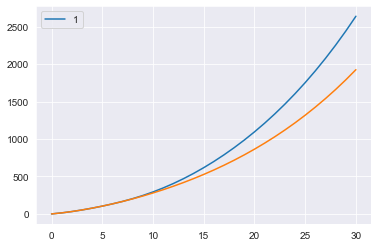

In [21]:
plt.plot(tot_deaths(sol_multi_regime1), label = '1')
plt.plot(tot_deaths(sol_multi_regime2))
plt.legend()

In [22]:
sol_sem_cid = results_base_rio_sem_cid.y

NameError: name 'results_base_rio_sem_cid' is not defined

In [ ]:
i = 3
plt.plot(sol_sem_cid[i]-sol_multi_regime1[i], label = legends[i])
plt.legend()
plt.show()

In [ ]:
def tot_deaths(res):
    return np.sum(res[:,0]) - np.sum(res, axis=0)

In [ ]:
params1 = params_rio_base[:-2]
params1[-1], params1[-3] = 0,0
params_rio_base = params_rio_base[:-2]
#params1, params_rio_base

In [ ]:
p1 = params[:]
p1[-1], p1[-2] = [0,0],[0,0]
#p1, params

In [ ]:
cii = np.array([90, 5, 0, 0, 4, 1, 0, 85, 10, 0, 0, 1, 4, 0])
paramsi = [[0.3, 0.3], [0.01, 0.02], [0, 0.5], [0, 0.5], [0.2, 0.2], [0.1, 0.1], [0, 0.2], [0.1, 0.1], [0, 0.4], [0.1, 0.1], [0.3, 0.2],
           [0.1, 0.1], [0.2, 0.1], [0.3, 0.3], [0.3, 0.3]]
paramsi2 = [[0.3, 0.3], [0.01, 0.02], [0, 0.5], [0, 0.5], [0.2, 0.2], [0.1, 0.1], [0, 0.2], [0.1, 0.1], [0, 0.4], [0.1, 0.1], [0.3, 0.2],
           [0.1, 0.1], [0.2, 0.1], [0, 0], [0,0]]

In [ ]:
g = lambda t, v: G(t, v, paramsi)
res = solve_ivp(g, (0, 3), cii, t_eval = np.arange(1, 3))
ci = res.y[:, -1]
print(type(ci), type(cii), len(ci), len(cii), len(res.y[0]))
g = lambda t, v: G(t, v, paramsi2)
res2 = solve_ivp(g, (3, 25), ci, t_eval = np.arange(3,26))
print(len(res2.y[0]))

In [ ]:
np.shape(ci), np.shape(cii), type(cii), type(ci)

In [ ]:
t_par_lst = [[10,paramsi],[25,paramsi2],[35,paramsi]]

ss = multi_regime_cidades(cii, 0, t_par_lst)

In [ ]:
i = 2
plt.plot(ss[i + 7])
plt.plot(ss[i + 0])

In [ ]:
plt.plot(tot_deaths(ss))

In [ ]:
t_par = 

In [ ]:
ss = multi_regime(CI[:7], 0, t_par)

In [ ]:
CI

In [ ]:
f_rio_base_sem_cid = lambda t, v: F(t, v, *params_rio_base[:-2])
results_base_rio_sem_cid = solve_ivp(f_rio_base_sem_cid, (1, 46), CI[:7], t_eval=range(1, 47))